# Environmental Sound Classification Using Local Binary Pattern and Audio Features Collaboration

[Ohini Kafui Toffa](mailto:ohini.kafui.toffa@umontreal.ca), Université de Montréal 
[Max Mignotte](mailto:mignotte@iro.umontreal.ca), Université de Montréal  

---

## Introduction

We implement here the part of the network that process the spectrogram in the three-stream network available in [Multi-stream Network With Temporal Attention For Environmental Sound Classification, X. Li and V. Chebiyyam and K. Kirchhoff](http://dx.doi.org/10.21437/Interspeech.2019-3019). The source code is used in IEEE Transactions on Multimedia https://ieeexplore.ieee.org/document/9248620 


## Depencies

This notebook requires some libraries and tools to be installed

    pip3 install librosa pydub openpyxl matplotlib seaborn 
    pip install git+https://github.com/detly/gammatone.git
    pip install --upgrade tensorflow-gpu
 

## Datasets
For experiments we used folowing datasets:<br>
- ESC dataset publicly avalaible at https://github.com/karoldvl/ESC-50 under [Creative Commons Attribution Non-Commercial license](http://creativecommons.org/licenses/by-nc/3.0/).  The *ESC-10* dataset consists of 10 categories of recordings (400 clips). ESC-50 has 50 classes (2 000 clips) in 5 thematic groups. Length of the audio is 5s and the sample is 44100.
We grabbed and updated the original code of the author to load and analyse the dataset. See author article bellow

 [K. J. Piczak. ESC: Dataset for Environmental Sound Classification. In Proceedings of the 23rd ACM international conference on Multimedia, pp. 1015-1018, ACM, 2015](http://dx.doi.org/10.1145/2733373.2806390)<br>
 

Load the dataset audio files list

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
records = pd.read_csv("ESC-50/esc50.csv") 
"""display header and first 5 rows"""
records.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Spectrogram Extraction

In [25]:
import sys
import numpy as np
import pydub
import librosa
import math
import gammatone.gtgram
    
class Clip:    
    RATE = 44100 #22050   # All recordings in ESC are 44.1 kHz
    FRAME = 2048    # nfft or frame size. We used wideband(see benefit of wideband in https://arxiv.org/pdf/1706.07156.pdf) 
    HOP_LENGTH = 1024 # Hop Length, half of the frame
    LBP_DIGITS = 4 # LBP-1D number of digits
        
    def __init__(self, audio, filename, fold, category, categoryname,  featuresFolder, esc10=False, duration=5000):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.fold = fold
        self.categoryname = categoryname
        self.category = category 
        self.duration = duration
        self.featuresFolder = featuresFolder
        self.esc10 = esc10
        self.loaded = False
        self.audio = audio
         
        try: 
            if self.audio is None:
                self._load_audio(duration)
            # compute the Mel spectogram and the MFCC
            self._compute_mel_mfcc()
            self.loaded = True
            self._save()
        except Exception as ex:
            print('Fail to load audio {0}.'.format(self.path))
            print(ex)
                
    def __exit__(self, exception_type, exception_value, traceback):
        if exception_type is not None:
            print (exception_type, exception_value, traceback)
        del self.audio
        del self.melspectrogram
        
    """Duration in seconds"""
    def _load_audio(self, duration):
        # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly duration seconds
        data = pydub.AudioSegment.silent(duration=duration)
        data = data.overlay(pydub.AudioSegment.from_file(self.path).set_frame_rate(Clip.RATE).set_channels(1))[0:duration]
        self.audio =((np.frombuffer(data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5))[0:int(duration*Clip.RATE)]   # convert to float
        maxLength = int(duration*Clip.RATE/1000)
        self.audio =self.audio[0:maxLength] # Crop to max length  
  
    def _compute_mel_mfcc(self):
        # Compute Mel Spectogram with 2048 FFT window length, HOP Length 1024, 128 bands
        self.melspectrogram = librosa.feature.melspectrogram(y=self.audio, n_fft=Clip.FRAME, 
                                                             sr=Clip.RATE, hop_length=Clip.HOP_LENGTH, n_mels=128)
        # Compute MFCC
        logamplitude = librosa.amplitude_to_db(self.melspectrogram)
        self.melspectrogram = np.resize(self.melspectrogram, (512,384))   
    
    def _save(self):
        dest = os.path.splitext(self.filename)[0];
        dest = '{0}/{1}'.format(self.featuresFolder, dest)
        imgShape = np.shape(self.melspectrogram)
        nbFeatures = 1
        np.save(dest,  np.resize(self.melspectrogram, (512,384,1)))    
    

### Quick view of a dog audio record

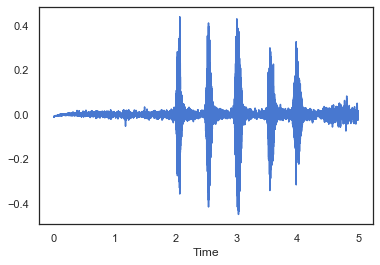

In [31]:
import IPython.display
import os
import glob
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import random
random.seed(20150420)
 
""" Load one item of the dataset: dog sound"""
clip = Clip(None,'ESC-50/1-30226-A-0.wav',1, 0,'dog','Features/ESC-50',True)
if clip.loaded:
    #plt.title('{0} : {1}'.format(clip.category, clip.filename))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time')
    plt.plot(np.arange(0, len(clip.audio)) / Clip.RATE, clip.audio)
else:
    del clip

In [32]:
IPython.display.Audio(clip.audio, rate=Clip.RATE) 

In [33]:
def augment(clip, index):
    n = 10
    filename = os.path.basename(clip.filename)
    nameWithoutExt = os.path.splitext(filename)[0]
    name = '{0}_{1}'.format(nameWithoutExt,index)    
    length = len(clip.audio)
    if index%n == 0:
        # Add white noise
        wn = np.random.randn(length)
        newAudio = clip.audio + 0.005*wn
    elif index%n == 1 or index%n == 7:
        # Time Shift
        time_shift = np.random.randint(int(length/2))
        newAudio = np.roll(clip.audio, time_shift)
    elif index%n == 2 or index%n == 8:
        # Time Stretch
        time_stretch =  np.random.uniform(0.8,1.2)
        newAudio = librosa.effects.time_stretch(clip.audio, time_stretch)
        if len(newAudio)>length:
            newAudio = newAudio[:length]
        else:
            newAudio = np.pad(newAudio, (0, length - len(newAudio)), "constant")      
    elif index%n == 3 or index%n == 9:
        # Pitch Shift
        pitch_shift =  np.random.randint(1,4)
        newAudio = librosa.effects.pitch_shift(clip.audio, Clip.RATE, n_steps=pitch_shift)
    elif index%n == 4:
        # Time Shift and Noise
        time_shift = np.random.randint(int(length/2))
        newAudio = np.roll(clip.audio, time_shift)        
        wn = np.random.randn(length)
        newAudio = newAudio + 0.005*wn
    elif index%n == 5:
        # Time Stretch and Noise
        time_stretch =  np.random.uniform(0.8,1.2)
        newAudio = librosa.effects.time_stretch(clip.audio, time_stretch)
        if len(newAudio)>length:
            newAudio = newAudio[:length]
        else:
            newAudio = np.pad(newAudio, (0, length - len(newAudio)), "constant")  
        wn = np.random.randn(length)
        newAudio = newAudio + 0.005*wn
    elif index%n == 6:
        # Pitch Shift and Noise
        pitch_shift =  np.random.randint(1,4)
        newAudio = librosa.effects.pitch_shift(clip.audio, Clip.RATE, n_steps=pitch_shift)
        wn = np.random.randn(length)
        newAudio = newAudio + 0.005*wn        
    return Clip(newAudio, name, clip.fold, clip.category, clip.categoryname, clip.featuresFolder, clip.esc10, clip.duration)

In [34]:
# White Noise
clipAugmented = augment(clip, 0)
IPython.display.Audio(clipAugmented.audio, rate=Clip.RATE)

In [35]:
# Time Shift
clipAugmented1 = augment(clip, 1)
IPython.display.Audio(clipAugmented1.audio, rate=Clip.RATE)

In [36]:
# Time Stretch
clipAugmented2 = augment(clip, 2)
IPython.display.Audio(clipAugmented2.audio, rate=Clip.RATE)

In [37]:
# Pitch Shift
clipAugmented3 = augment(clip, 3)
IPython.display.Audio(clipAugmented3.audio, rate=Clip.RATE)

Mel Spectogram: (512, 384)


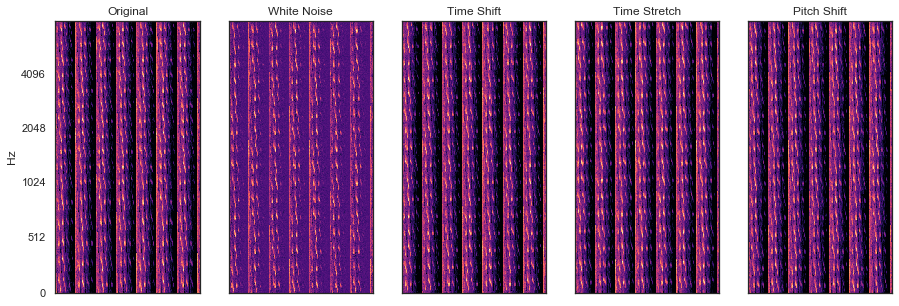

In [38]:
print('Mel Spectogram:', np.shape(clip.melspectrogram))
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,5))
ax1.title.set_text('Original')
librosa.display.specshow(librosa.power_to_db(clip.melspectrogram.transpose(), ref=np.max), ax=ax1, y_axis='mel', fmax=8000)
ax2.title.set_text('White Noise')
librosa.display.specshow(librosa.power_to_db(clipAugmented.melspectrogram.transpose(), ref=np.max), ax=ax2, fmax=8000)
ax3.title.set_text('Time Shift')
librosa.display.specshow(librosa.power_to_db(clipAugmented1.melspectrogram.transpose(), ref=np.max), ax=ax3, fmax=8000)
ax4.title.set_text('Time Stretch')
librosa.display.specshow(librosa.power_to_db(clipAugmented2.melspectrogram.transpose(), ref=np.max), ax=ax4, fmax=8000)
ax5.title.set_text('Pitch Shift')
librosa.display.specshow(librosa.power_to_db(clipAugmented3.melspectrogram.transpose(), ref=np.max), ax=ax5, fmax=8000)

## Dataset Load

In [56]:
def extract_features(filename, fold, category, categoryname, esc10, duration, features_folder, augmentNb=10):
    dataFrames = []
    clip = Clip(None,filename, fold, category, categoryname, features_folder, esc10, duration)
    if clip.loaded:
        dataFrame = pd.DataFrame({
            'filename': os.path.splitext(clip.filename)[0], 
            'fold': clip.fold, 
            'category': clip.category, 
            'category_name': clip.categoryname,
            'augmented': -1,
            'esc10': esc10}, index=[0])
        dataFrames.append(dataFrame)
        if augmentNb > 0:
            for i in range(augmentNb):
                augmented = augment(clip, i)
                augmentedFrame = pd.DataFrame({
                'filename': os.path.splitext(augmented.filename)[0], 
                'fold': augmented.fold, 
                'category': augmented.category, 
                'category_name': augmented.categoryname,
                'augmented': i,
                'esc10':esc10}, index=[0])
                dataFrames.append(augmentedFrame)
    return dataFrames

In [60]:
import os
from datetime import datetime
import multiprocessing
from joblib import Parallel, delayed
CPU_COUNT = multiprocessing.cpu_count()

#from collections import defaultdict
def load_dataset(records, featuresFolder='Features/ESC-50', batch_size=100):
    starttime = datetime.now()
    # Convert to dataFrame 
    dataFrame = pd.DataFrame(records)
    recCount = len(dataFrame.index)
    batch_size = batch_size
    metas = []
    for k in range(recCount // batch_size + 1):
        start = k * batch_size
        end = (k + 1) * batch_size
        dtfPerClip = []
        if end > recCount:
            end = recCount
        dtfPerClip = Parallel(n_jobs=CPU_COUNT)(delayed(extract_features)(
        'ESC-50/{0}'.format(dataFrame.loc[i,'filename']),
        dataFrame.loc[i,'fold'], 
        dataFrame.loc[i,'target'], 
        dataFrame.loc[i,'category'], 
        dataFrame.loc[i,'esc10'],
        5000,
        featuresFolder,
        4
        ) for i in range(start, end))
        metas.extend(dtfPerClip)
        print('NbClips processed:{0}'.format(end))
            
    IPython.display.clear_output()
    duration = datetime.now() - starttime
    print('Load of {0} records done in {1}.'.format(recCount, duration))  
    return metas

## ESC-10
Use ESC-10 for proof of concept

In [61]:
meta = load_dataset(records, 'Features/ESC-50')

Load of 2000 records done in 0:08:01.344605.


In [67]:
meta = pd.read_csv("Features/ESC-50/meta.csv") 

In [68]:
meta_esc10 = meta[meta['esc10']==True]
len(meta_esc10.index)

2000

# Sound classification using CNN

In [74]:
import tensorflow as tf
import numpy as np
# featIndexes is array like [1,3,5]
class Features_Generator(tf.keras.utils.Sequence) :
    def __init__(self, filenames, labels, featuresFolder, batch_size) :
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.featuresFolder = featuresFolder
    
    def __len__(self) :
        return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(np.int)
   
    def __getitem__(self, idx) :
        batch_x = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        feat = np.array([np.load('{0}/{1}.npy'.format(self.featuresFolder, file_name)) for file_name in batch_x])/255.0
        feat = np.resize(feat,(len(batch_x), 512,384,1)) # to simulate input size of (batch_size, 512, 384, 1)
        return feat, np.array(batch_y)

In [80]:
import tensorflow as tf
from datetime import datetime
l2_rate = 0.0005
relu_rate = 0.01

def model_CNN(train_batch_generator,train_Y,test_batch_generator,test_Y,batch_size,
              epochs,nb_class,fold):
    print('Building model') 
    IMG_SHAPE = (512, 384, 1)# (216, 128, nb_features)
    print(IMG_SHAPE)
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),
                           input_shape=IMG_SHAPE,padding='same'),       
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
        
    tf.keras.layers.Conv2D(16, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),    
        
    tf.keras.layers.MaxPooling2D((4, 3)),# 128x128 
        
    tf.keras.layers.Conv2D(16, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
        
    tf.keras.layers.Conv2D(32, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),  
        
    tf.keras.layers.MaxPooling2D((4, 4)), #32x32
        
    tf.keras.layers.Conv2D(32, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(), 
        
    tf.keras.layers.Conv2D(64, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),   
        
    tf.keras.layers.MaxPooling2D((2, 2)), #16x16
        
    tf.keras.layers.Conv2D(64, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),   
        
    tf.keras.layers.MaxPooling2D((2, 2)), #8x8
        
    tf.keras.layers.Conv2D(128, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),   
        
    tf.keras.layers.MaxPooling2D((2, 2)),  # 4x4
        
    tf.keras.layers.Conv2D(128, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),   
        
    tf.keras.layers.Conv2D(256, (3, 3),use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(l2_rate),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
        
    tf.keras.layers.MaxPooling2D((2, 2)), #2x2
        
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.Dense(1024),
        
    tf.keras.layers.Dense(nb_class, activation='softmax')
    ]) 

    model.summary()

    model_path = 'Results/fold{0}.h5'.format(fold)
    opti = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.99, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opti, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    #print(model.metrics_names)
    print('Training model')   
    # To measure the wole training time
    start = datetime.now()
    # To measure time per epoch
    history = model.fit_generator(generator=train_batch_generator,
                        epochs = epochs,
                        verbose = 1,
                        shuffle=False,
                        validation_data = test_batch_generator,
                        use_multiprocessing = False)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    
    # In Tensorflow 2.0 acc => accuracy
    print(history.history.keys())
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    
    
    return val_acc[len(val_acc)-1]

In [81]:
def to_percentage(number):
    return int(number * 1000) / 10.0

In [84]:
def classify_CNN(metas, esc10=False, nb_class=10, nb_fold=5, epochs=10, batch_size=100,
                featuresFolder='Features/ESC-50',urban=False):
    results = []
    label_string = 'category'
    if esc10:
        label_string = 'esc10label'
    start = datetime.now()
    
    for fold in range(1, nb_fold+1):
        train = metas[metas['fold'] != fold].copy()
        test = metas[metas['fold'] == fold].copy()
        train_Y = train[label_string]
        test_Y = test[label_string]
        train_files = train['filename']
        test_files = test['filename']     
            
        train_batch_generator = Features_Generator(train_files, train_Y, featuresFolder, batch_size)
        test_batch_generator = Features_Generator(test_files, test_Y, featuresFolder, batch_size)
        accuracy = model_CNN(train_batch_generator,train_Y,test_batch_generator,test_Y,batch_size,epochs,nb_class,fold)  
        results.append(accuracy)
        
    print('Average accuracy: {0}%\n'.format(to_percentage(np.mean(results))))
    duration = datetime.now() - start
    print("Whole Training completed in time: ", duration)    
    return results

In [85]:
# Run on the mfcc to simulate one feature input
classify_CNN(meta_esc10,esc10=True,nb_class=10,epochs=1,nb_fold=5,batch_size=1)

Building model
(512, 384, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 512, 384, 16)      144       
_________________________________________________________________
batch_normalization_10 (Batc (None, 512, 384, 16)      64        
_________________________________________________________________
re_lu_10 (ReLU)              (None, 512, 384, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 512, 384, 16)      2304      
_________________________________________________________________
batch_normalization_11 (Batc (None, 512, 384, 16)      64        
_________________________________________________________________
re_lu_11 (ReLU)              (None, 512, 384, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooli

1600/1600 [==============================] - 189s 118ms/step - loss: 10.2652 - acc: 0.1112 - val_loss: 4.3495 - val_acc: 0.1000
Training completed in time:  0:03:09.901942
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
Building model
(512, 384, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 512, 384, 16)      144       
_________________________________________________________________
batch_normalization_30 (Batc (None, 512, 384, 16)      64        
_________________________________________________________________
re_lu_30 (ReLU)              (None, 512, 384, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 512, 384, 16)      2304      
_________________________________________________________________
batch_normalization_31 (Batc (None, 512, 384, 16)      64        
_

Training model
1600/1600 [==============================] - 199s 124ms/step - loss: 12.4202 - acc: 0.1831 - val_loss: 5.4955 - val_acc: 0.1000
Training completed in time:  0:03:20.133770
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
Building model
(512, 384, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 512, 384, 16)      144       
_________________________________________________________________
batch_normalization_50 (Batc (None, 512, 384, 16)      64        
_________________________________________________________________
re_lu_50 (ReLU)              (None, 512, 384, 16)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 512, 384, 16)      2304      
_________________________________________________________________
batch_normalization_51 (Batc (None, 512, 384, 16)   

[0.06, 0.1, 0.13, 0.1, 0.13]

It took 16m:27s to train the ESC-10 for 1 epoch